# TODO
* Split pre-processing into separate notebook
* RT regression model
    * choice ~ prev_choice + prev_reward + prev_RT
* Run RL models on new, clean data
* Plot results using old notebook
* Add RTs into model
    * Modulates alpha? -> dopamine = RPE
    * Modulates beta? -> dopamine = response vigor
* Is the RT model better than the no-RT model? -> Plot (W)AIC etc.
* Hierarchical fitting
    * Baseline model: $\theta \sim 1$ (just regular group-level priors)
    * Age group differences: $\theta \sim agegroup$ (two groups based on agegroup)
    * Meta-learning: $\theta \sim session$ (linear effect of session? quadratic?)
    * Age group and meta-learning: $\theta \sim session + agegroup$ (how do I specify within- vs between-participant factors? {session vs agegroup)
    * Differences in meta-learning based on agegroup: $\theta \sim session \times agegroup$
    * Model comparison using WAIC
* CHECK Basic RT plots
    * CHECK RT over sessions, blocks, trials
    * CHECK RT differences reward vs no-reward; correct vs incorrect

# Imports etc.

In [1]:
import ipdb
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import scipy
import statsmodels.formula.api as smf

from Functions import get_info_from_fullID, add_meta_column, sigmoid, get_session

In [2]:
fitted_param_dir = 'C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/'
mouse_data_dir = 'C:/Users/maria/MEGAsync/SLCN/PSMouseData'
plot_dir = 'C:/Users/maria/MEGAsync/SLCN/models/plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [3]:
n_trial_cutoff = 500  # 500 as of 2020/07/21
n_session_cutoff = 10  # 10 as of 2020/07/21

# Get cleaned mouse data

In [4]:
true_dat_all = pd.read_csv(os.path.join(mouse_data_dir, 'mouse_true_dat_raw.csv'))
true_dat_all['switch'] = true_dat_all['switch'].astype(int)
true_dat_all['stay'] = 1 - true_dat_all['switch']
true_dat_all

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,block_length,block_trial,trials2switch,session,rew_1&2ago,cor_1&2ago,act_1&2ago,meta,switch,stay
0,0.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,12.0,0.0,0.0,0.0,nn,nn,nn,1-3,1,0
1,0.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,12.0,1.0,1.0,0.0,0n,0n,0n,1-3,0,1
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,12.0,2.0,2.0,0.0,00,00,00,1-3,1,0
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,12.0,3.0,3.0,0.0,10,10,10,1-3,0,1
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,12.0,4.0,4.0,0.0,11,11,11,1-3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350164,NaN,NaN,NaN,NaN,768,NaN,1309021,Adult,Female,90,...,NaN,NaN,NaN,15.0,nn,nn,nn,NaN,1,0
350165,NaN,NaN,NaN,NaN,769,NaN,1309021,Adult,Female,90,...,NaN,NaN,NaN,15.0,nn,nn,nn,NaN,1,0
350166,NaN,NaN,NaN,NaN,770,NaN,1309021,Adult,Female,90,...,NaN,NaN,NaN,15.0,nn,nn,nn,NaN,1,0
350167,NaN,NaN,NaN,NaN,771,NaN,1309021,Adult,Female,90,...,NaN,NaN,NaN,15.0,nn,nn,nn,NaN,1,0


In [5]:
true_dat = pd.read_csv(os.path.join(mouse_data_dir, 'true_dat.csv'))
true_dat['switch'] = true_dat['switch'].astype(int)
true_dat['stay'] = 1 - true_dat['switch']
true_dat

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,block_trial,trials2switch,session,rew_1&2ago,cor_1&2ago,act_1&2ago,meta,switch,excluded,stay
0,0.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,0.0,0.0,0.0,nn,nn,nn,1-3,1,False,0
1,0.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,1.0,1.0,0.0,0n,0n,0n,1-3,0,False,1
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,2.0,2.0,0.0,00,00,00,1-3,1,False,0
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,3.0,3.0,0.0,10,10,10,1-3,0,False,1
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,4.0,4.0,0.0,11,11,11,1-3,0,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191495,0.0,0.0,3.70600,0.0,495,26.0,1308321,Adult,Female,83,...,2.0,2.0,10.0,00,10,10,9-11,1,False,0
191496,0.0,0.0,1.91100,0.0,496,26.0,1308321,Adult,Female,83,...,3.0,3.0,10.0,00,01,01,9-11,0,False,1
191497,1.0,1.0,3.54000,1.0,497,26.0,1308321,Adult,Female,83,...,4.0,4.0,10.0,00,00,00,9-11,1,False,0
191498,1.0,0.0,0.52400,1.0,498,26.0,1308321,Adult,Female,83,...,5.0,5.0,10.0,10,10,10,9-11,0,False,1


In [6]:
# Make agegroup and sex ordered categorical columns
true_dat['agegroup'] = pd.Categorical(true_dat.agegroup, categories=('Juvenile', 'Adult'), ordered=True)
true_dat['sex'] = pd.Categorical(true_dat.sex, categories=('Male', 'Female'), ordered=True)
true_dat_all['agegroup'] = pd.Categorical(true_dat_all.agegroup, categories=('Juvenile', 'Adult'), ordered=True)
true_dat_all['sex'] = pd.Categorical(true_dat_all.sex, categories=('Male', 'Female'), ordered=True)

# Functions to make plots

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\0_session_n_mouse.png


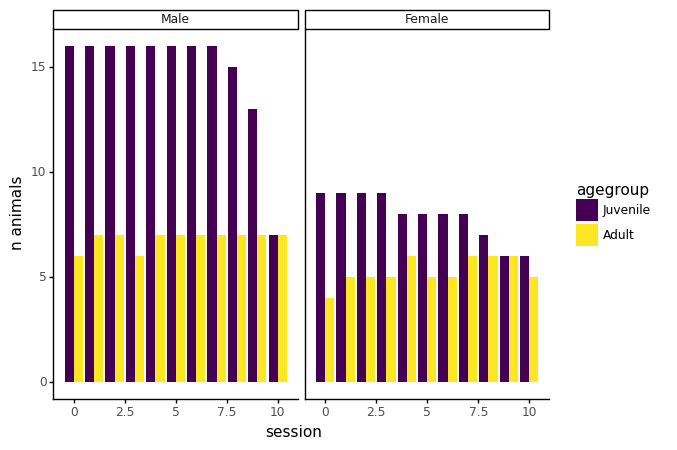

<ggplot: (147285303980)>

In [7]:
def plot_session_n(data, suf):
    
    g = (gg.ggplot(data, gg.aes('session', fill='agegroup'))
         + gg.geom_bar(position=gg.position_dodge(width=0.9))
         + gg.facet_grid('~ sex')
         + gg.labs(y='n animals', color='')
        )
    
    g.save(os.path.join(plot_dir, '0_session_n_{}.png'.format(suf)))
    return g

# Example use
plot_session_n(true_dat[true_dat.trial==0], 'mouse')

In [9]:
def plot_n_trials(data, suf):
    
    g = (gg.ggplot(data, gg.aes('session', 'n_trials')) #, fill='agegroup', group='agegroup'))
    #      + gg.stat_summary(geom='line')
         + gg.stat_summary(geom='bar', position=gg.position_dodge(width=0.9))
         + gg.geom_point(gg.aes(color='agegroup'), position='jitter', size=0.5)
         + gg.geom_hline(yintercept=n_trial_cutoff, linetype='dotted', color='green')
         + gg.geom_vline(xintercept=n_session_cutoff, linetype='dotted', color='green')
         + gg.labs(color='')
         + gg.facet_grid('~ sex')
        )
    
    g.save(os.path.join(plot_dir, '0_sesssion_ntrials_{}.png'.format(suf)))
    return g

# # Example use
# plot_n_trials(true_dat, 'mouse')

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\1_rt_histogram_mouse.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 381'. Pick better value with 'binwidth'.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 381'. Pick better value with 'binwidth'.


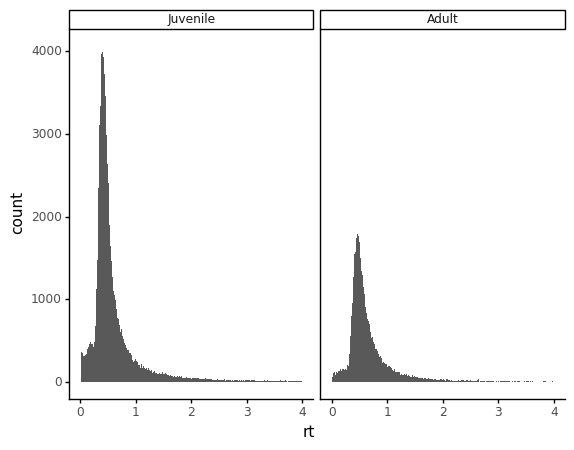

<ggplot: (147285491417)>

In [10]:
def plot_rt_histogram(data, suf):
    
    g = (gg.ggplot(data, gg.aes('rt'))
         + gg.geom_histogram()
         + gg.facet_grid('~ agegroup')
        )
    g.save(os.path.join(plot_dir, '1_rt_histogram_{}.png'.format(suf)))
    
    return g

# Example use
plot_rt_histogram(true_dat, 'mouse')

In [11]:
def plot_basic_rts(data, suf):

    # Basics
    gs = (gg.ggplot(data, gg.aes('session', 'rt', color='agegroup', group='agegroup'))
         + gg.stat_summary()
         + gg.stat_summary(geom='line')
         + gg.labs(color='')
         + gg.facet_grid('~ sex')
        )
    gs.save(os.path.join(plot_dir, '1_session_rt_{}.png'.format(suf)))

    gt = gs + gg.aes('trial')
    gt.save(os.path.join(plot_dir, '1_trial_rt_{}.png'.format(suf)))
    
    gb = gs + gg.aes('block')
    gb.save(os.path.join(plot_dir, '1_block_rt_{}.png'.format(suf)))
  
    gm = gs + gg.aes('meta')
    gm.save(os.path.join(plot_dir, '1_meta_rt_{}.png'.format(suf)))

    ga = gs + gg.aes('age')
    ga.save(os.path.join(plot_dir, '1_age_rt_{}.png'.format(suf)))
    
    # More fancy
    g2 = gs + gg.aes('trials2switch')
    g2.data = data.loc[data.trials2switch < 15]
    g2.save(os.path.join(plot_dir, '1_trialstoswitch_rt_{}.png'.format(suf)))
    
#     gc = (gs
#           + gg.aes(x='cor_1&2ago', color='factor(switch)', group='factor(switch)')
#           + gg.facet_grid('~ agegroup')
#          )
#     gc.data = data.loc[data['cor_1&2ago'].isin(['00', '01', '10', '11'])]
#     gc.save(os.path.join(plot_dir, '1_cor12ago_rt_{}.png'.format(suf)))

#     g1 = gc + gg.aes('rew_1&2ago')
#     g1.data = data.loc[data['rew_1&2ago'].isin(['00', '01', '10', '11'])]
#     g1.save(os.path.join(plot_dir, '1_rew12ago_rt_{}.png'.format(suf)))
    
    return gt

# Exaple use
plot_basic_rts(true_dat, 'mouse')

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\1_session_rt_mouse.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\1_trial_rt_mouse.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\1_block_rt_mouse.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Savin

KeyboardInterrupt: 

In [ ]:
def plot_meta_correct(data, suf):
    
    g = (gg.ggplot(data, gg.aes('meta', 'correct', color='agegroup', group='agegroup'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.facet_grid('~ sex')
     + gg.labs(x='Sessions', color='')
    )
    
    g.save(os.path.join(plot_dir, '1_meta_correct_{}.png'.format(suf)))
    return g
    
# Example use
plot_meta_correct(true_dat, 'mouse')

In [ ]:
def make_blocktrial_correct_plot(data, suf):
    
    g = (gg.ggplot(data, gg.aes('block_trial', 'correct', color='agegroup'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.coord_cartesian(xlim=(0, 40))
     + gg.facet_grid('meta ~ sex')
    )
    g.save(os.path.join(plot_dir, '1_trial_correct_{}.png'.format(suf)))
    
    g2 = g + gg.aes(y='reward')    
    g2.save(os.path.join(plot_dir, '1_trial_reward_{}.png'.format(suf)))
    return g
    
# Example use
make_blocktrial_correct_plot(true_dat, 'mouse')

In [ ]:
def make_session_correct_plot(data, suf):

    g = (gg.ggplot(data, gg.aes('session', 'correct', color='agegroup'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.facet_grid(' ~ sex')
    )
    g.save(os.path.join(plot_dir, '1_session_correct_{}.png'.format(suf)))
    
    g2 = g + gg.aes(y='reward')    
    g2.save(os.path.join(plot_dir, '1_session_reward_{}.png'.format(suf)))
    return g
    
# Example use
make_session_correct_plot(true_dat, 'mouse')

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\pandas\core\computation\expressions.py:200: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
<ipython-input-26-06f0c4436241>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\2_rew12back_switch_mouse.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\maria

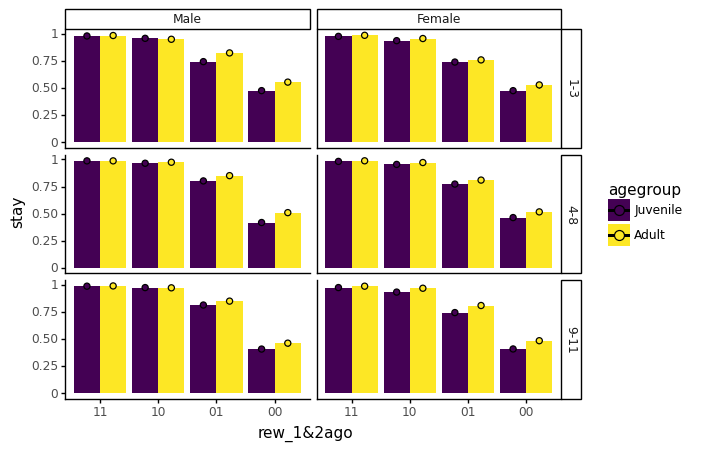

<ggplot: (147288281233)>

In [26]:
def make_12ago_plot(data, suf=''):
    
    sub_dat = data.loc[(data['rew_1&2ago'] != '0n') * (data['rew_1&2ago'] != '1n') * (data['rew_1&2ago'] != 'nn')]
    sub_dat['rew_1&2ago'] = pd.Categorical(sub_dat['rew_1&2ago'], ordered=True, categories=('11', '10', '01', '00'))    

    g = (gg.ggplot(sub_dat, gg.aes('rew_1&2ago', 'stay', fill='agegroup', group='agegroup'))
         + gg.stat_summary(geom='bar', position=gg.position_dodge(width=0.9))
         + gg.stat_summary(position=gg.position_dodge(width=0.9))
         + gg.facet_grid('meta ~ sex')
    )
    g.save(os.path.join(plot_dir, '2_rew12back_switch_{}.png'.format(suf)))
    
    g2 = g + gg.aes(y='correct')    
    g2.save(os.path.join(plot_dir, '2_rew12back_correct_{}.png'.format(suf)))
    
    g3 = g + gg.aes(fill='meta', group='meta') + gg.facet_grid('agegroup ~ sex')
    g3.save(os.path.join(plot_dir, '2_rew12back_meta_{}.png'.format(suf)))
    return g
    
# Example use
make_12ago_plot(true_dat, 'mouse')

In [ ]:
def make_trials2switch_plot(data, suf=''):
    
    g = (gg.ggplot(data, gg.aes('trials2switch', 'correct', color='agegroup', group='agegroup'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.coord_cartesian(xlim=(-3, 10))
     + gg.facet_grid('meta ~ sex')
    )
    g.save(os.path.join(plot_dir, '3_trials2switch_{}.png'.format(suf)))
    
    g2 = g + gg.aes(color='meta', group='meta') + gg.facet_grid('agegroup ~ sex')
    g2.save(os.path.join(plot_dir, '3_trials2switch_meta_{}.png'.format(suf)))
    return g

# Example use
make_trials2switch_plot(true_dat, suf='mouse')

In [ ]:
def plot_asymptotic_correct(data, title, suf=''):
        
    g = (gg.ggplot(data, gg.aes(x='meta', y='correct', color='agegroup', group='agegroup'))
         + gg.stat_summary(position=gg.position_dodge(width=0.1))
         + gg.stat_summary(position=gg.position_dodge(width=0.1), geom='line')
#          + gg.coord_cartesian(ylim=(0.75, 1))
#          + gg.theme(axis_text_x=gg.element_blank())
         + gg.labs(xlab='Session', color='', title=title)
         + gg.facet_grid('~ sex')
        )
    
    g.save(os.path.join(plot_dir, '4_asympt_{}.png'.format(suf)))
    return g
    
# Example use
sub_dat = true_dat[(true_dat.trials2switch <= -1)]
plot_asymptotic_correct(sub_dat, title='1-3 trials before switch', suf='bef_mouse')
# sub_dat = true_dat[(true_dat.trials2switch >= 7) & (true_dat.trials2switch <= 12)]
# plot_asymptotic_correct(sub_dat, title='7-12 trials after switch', suf='after_mouse')

In [ ]:
def make_age_reward_plot(data, suf):
    
    g = (gg.ggplot(data, gg.aes('age', 'correct', color='factor(meta)', group='factor(meta)'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.facet_grid('agegroup ~ sex')
    )
    g.save(os.path.join(plot_dir, '1_age_correct_{}.png'.format(suf)))

    g2 = g + gg.aes(y='reward')    
    g2.save(os.path.join(plot_dir, '1_age_reward_{}.png'.format(suf)))

    g3 = g + gg.aes(color='factor(session)', group='factor(session)')
    g3.save(os.path.join(plot_dir, '1_age_correct_session_{}.png'.format(suf)))
    return g
    
# Example use
make_age_reward_plot(true_dat, 'mouse')

In [ ]:
def make_block_correct_plot(data, suf):
    
    g = (gg.ggplot(data, gg.aes('block', 'correct', color='agegroup', group='agegroup'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.coord_cartesian(xlim=(0, 20))
     + gg.facet_grid('meta ~ sex')
    )
    g.save(os.path.join(plot_dir, '1_block_correct_{}.png'.format(suf)))
    
    g2 = g + gg.aes(y='reward')    
    g2.save(os.path.join(plot_dir, '1_block_reward_{}.png'.format(suf)))
    
    g3 = g + gg.aes(color='meta', group='meta') + gg.facet_grid('agegroup ~ sex')
    g3.save(os.path.join(plot_dir, '1_block_correct_meta_{}.png'.format(suf)))
    return g
    
# Example use
make_block_correct_plot(true_dat, 'mouse')

# Plot

In [ ]:
# Summarize over session to count number of trials
def get_n_trial_dat(true_dat):
    
    n_trial_dat = true_dat[['animal', 'session', 'action', 'sex', 'agegroup']
                          ].groupby(['animal', 'session', 'sex', 'agegroup']
                          ).agg(['count']).reset_index().rename(columns={'action': 'n_trials'})
    return n_trial_dat

# # Example use
# get_n_trial_dat(true_dat_all)

In [ ]:
# Plot mouse data
print("Plotting basics...")
plot_session_n(true_dat_all[true_dat_all.trial==0], 'all_mouse')
plot_n_trials(get_n_trial_dat(true_dat_all), 'all_mouse')
plot_session_n(true_dat[true_dat.trial==0], 'mouse')
plot_n_trials(get_n_trial_dat(true_dat), 'mouse')

print("Plotting analyses...")
plot_basic_rts(true_dat, 'mouse')
plot_rt_histogram(true_dat, 'mouse')
sub_dat = true_dat[(true_dat.trials2switch <= -1)]
plot_asymptotic_correct(sub_dat, title='1-3 trials before switch', suf='bef_mouse')
sub_dat = true_dat[(true_dat.trials2switch >= 7) & (true_dat.trials2switch <= 12)]
plot_asymptotic_correct(sub_dat, title='7-12 trials after switch', suf='after_mouse')
plot_meta_correct(true_dat, suf='mouse')
make_trials2switch_plot(true_dat, suf='mouse')
make_12ago_plot(true_dat, 'mouse')
make_blocktrial_correct_plot(true_dat, 'mouse')
make_block_correct_plot(true_dat, 'mouse')
make_session_correct_plot(true_dat, 'mouse')
make_age_reward_plot(true_dat, 'mouse')

## Analyze simulated data

In [ ]:
# # Define simulations to be analzed
# n_agents = 100
# modelnames = [f for f in os.listdir(fitted_param_dir) if ('.csv' in f) and ('params' in f)]
# model_names = [modelname.split('_')[1] for modelname in modelnames]
# print(model_names)
# # model_names.reverse()
# # model_names = [ 'Bbspr', 'Bbp', 'Bbpr', 'Bb', 'B', 'RLabcd', 'RLabcpd', 'RLabcpnd', 'RLabcpnxd', 'RLabd', 'RLabnp2d', 'RLab']

# # Read in and format simulated data
# for model_name in model_names:
#     print("Model {}".format(model_name))
#     simulation_dir = os.path.join(fitted_param_dir, 'simulations/simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
#     if save_or_load_sim_mouse_dat == 'save':
#         sim_dat = pd.read_csv(simulation_dir)
#         sim_dat = format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)
#     else:
#         sim_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)))
#     sim_dat = add_meta_column(sim_dat)
#     sim_dat['agegroup'] = pd.Categorical(sim_dat['agegroup'], ordered=True, categories=('Juvenile', 'Adult'))
    
#     # Plot simulated data
#     print("Plotting...")
#     make_trials2switch_plot(sim_dat, suf='sim' + model_name)
#     make_12ago_plot(sim_dat, 'sim' + model_name)
#     make_blocktrial_correct_plot(sim_dat, 'sim' + model_name)
#     make_block_correct_plot(sim_dat, 'sim' + model_name)
#     make_session_correct_plot(sim_dat, 'sim' + model_name)
#     make_age_reward_plot(sim_dat, 'sim' + model_name)